<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week03/Week03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Price Prediction with Deep Learning



## Import Required Libraries



In [2]:
!pip install mlflow
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

# For experiment tracking
import mlflow
import mlflow.tensorflow
import os
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')

## Load and Explore the Dataset



In [3]:
# Load the California Housing dataset
housing = fetch_california_housing()

# Create a pandas DataFrame
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseValue'] = housing.target

# Display dataset information
print(f"Dataset shape: {df.shape}")
print("\nFeatures:")
print(housing.feature_names)
print("\nTarget variable: MedHouseValue")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Summary statistics
print("\nSummary statistics:")
print(df.describe().round(2))

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (20640, 9)

Features:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target variable: MedHouseValue

First 5 rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseValue  
0    -122.23          4.526  
1    -122.22          3.585  
2    -122.24          3.521  
3    -122.25          3.413  
4    -122.25          3.422  

Summary statistics:
         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
count  20640.00  20640.00  20640.00   20640.00    20640.00  20640.00   
mean       3.87

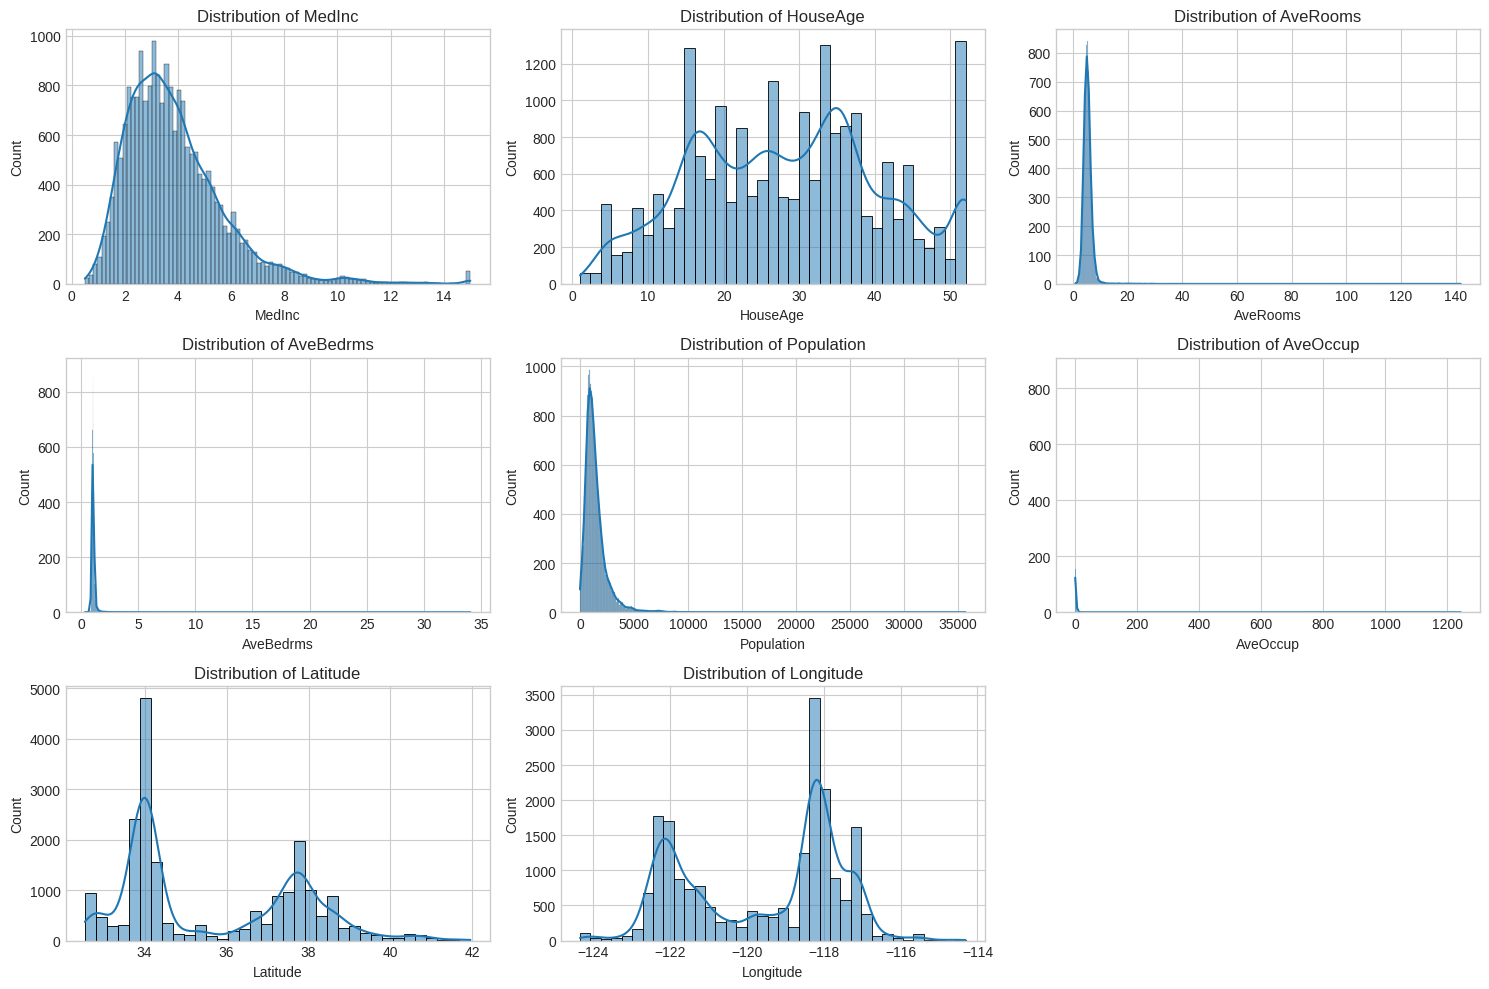

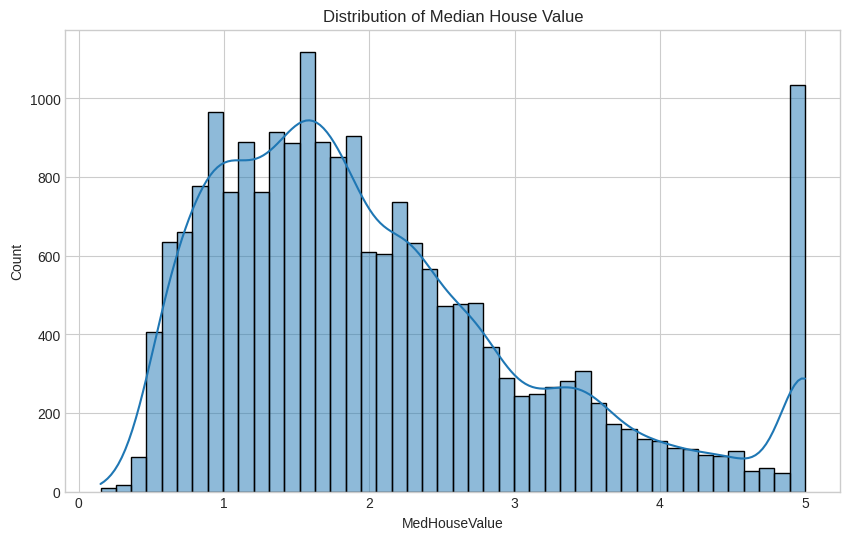

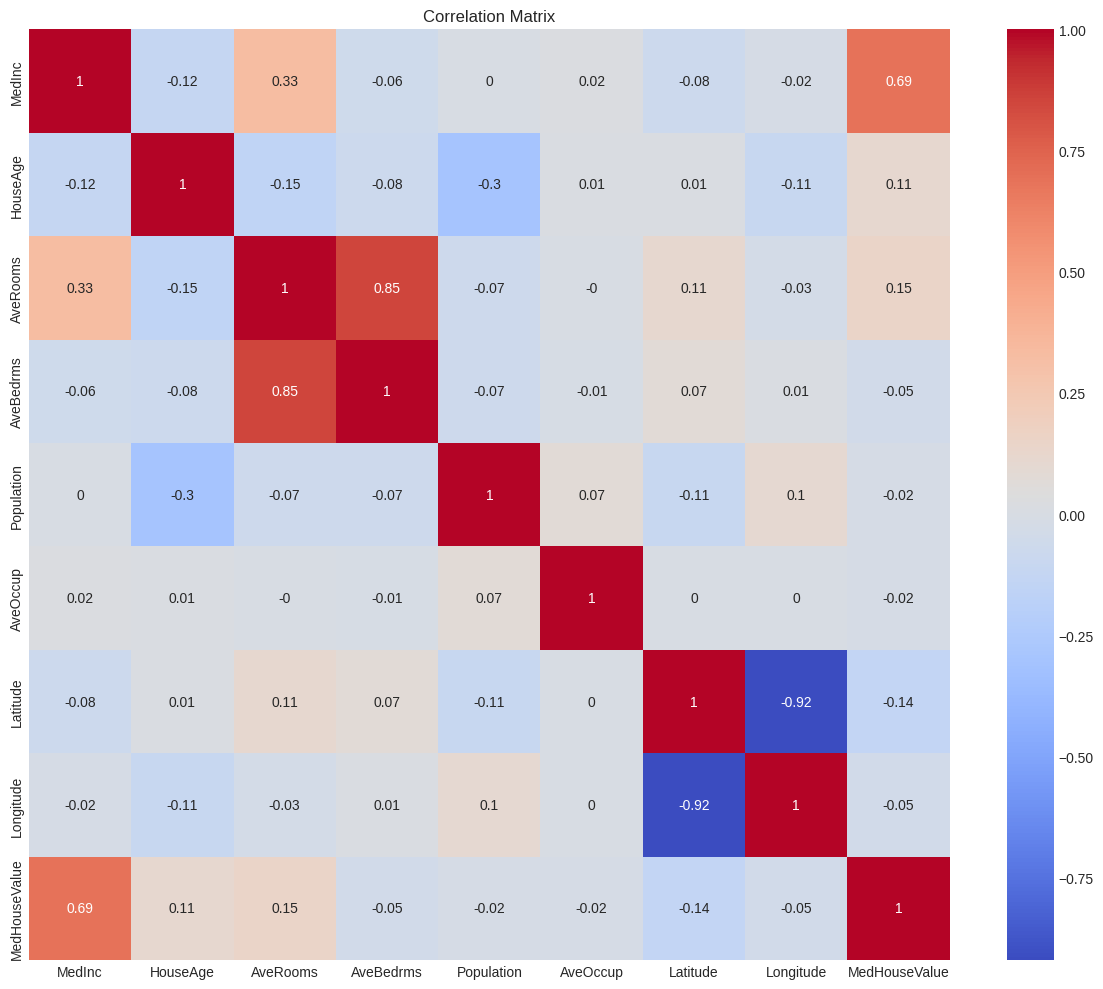

In [4]:
# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(housing.feature_names):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['MedHouseValue'], kde=True)
plt.title('Distribution of Median House Value')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


## Data Preprocessing

Now we'll prepare the data for our deep learning model:
1. Split the dataset into training, validation, and test sets
2. Standardize the features to have zero mean and unit variance
3. Verify the preprocessing results

In [5]:
# Split features and target
X = df.drop('MedHouseValue', axis=1).values
y = df['MedHouseValue'].values

# First split: separate test set (20% of data)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Second split: separate validation set (25% of remaining data, 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Verify scaling results (mean should be close to 0, std dev close to 1)
print("\nTraining set after standardization:")
print(f"Mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Standard deviation: {X_train_scaled.std(axis=0).round(3)}")

# Create feature name mapping for future reference
feature_names = housing.feature_names
feature_dict = {i: name for i, name in enumerate(feature_names)}

Training set: 12384 samples
Validation set: 4128 samples
Test set: 4128 samples

Training set after standardization:
Mean: [-0.  0.  0. -0.  0. -0.  0. -0.]
Standard deviation: [1. 1. 1. 1. 1. 1. 1. 1.]


## Define Model Building Function


In [6]:
def build_model(input_dim,
                hidden_layers=[64, 32],
                activation='relu',
                dropout_rate=0.2,
                learning_rate=0.001,
                l2_reg=0.0):

    model = Sequential()

    # Input layer
    model.add(Dense(hidden_layers[0],
                    activation=activation,
                    input_dim=input_dim,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units,
                        activation=activation,
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer (linear activation for regression)
    model.add(Dense(1))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

## Create Training and Evaluation Functions



In [7]:
def train_model(model, X_train, y_train, X_val, y_val,
                batch_size=32, epochs=100,
                patience=20, run_name=None):

    # Set up TensorBoard callback
    log_dir = f"./logs/{run_name}_{int(time.time())}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    # Start MLflow run
    with mlflow.start_run(run_name=run_name) as run:
        # Log parameters
        mlflow.log_params({
            "batch_size": batch_size,
            "epochs": epochs,
            "patience": patience,
            "model_summary": str(model.summary())
        })

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, tensorboard_callback],
            verbose=1
        )

        # Evaluate on validation set
        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)

        # Make predictions
        y_val_pred = model.predict(X_val).flatten()

        # Calculate additional metrics
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(y_val, y_val_pred)

        # Log metrics
        mlflow.log_metrics({
            "val_loss": val_loss,
            "val_mae": val_mae,
            "val_mse": val_mse,
            "val_rmse": val_rmse,
            "val_r2": val_r2
        })

        # Log model
        mlflow.tensorflow.log_model(model, "model")

        # Log the training history as a JSON artifact
        with open("history.json", "w") as f:
            import json
            json.dump({k: list(map(float, v)) for k, v in history.history.items()}, f)
        mlflow.log_artifact("history.json")

        print(f"Run ID: {run.info.run_id}")
        print(f"RMSE: {val_rmse:.4f}")
        print(f"MAE: {val_mae:.4f}")
        print(f"R²: {val_r2:.4f}")

    return history, model

def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    # Create residual plot
    plt.figure(figsize=(10, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    # Create actual vs predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.show()

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

## Hyperparameter Configurations



In [8]:
# Initialize MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("California Housing Price Prediction")

# Define hyperparameter configurations
configs = [
    {
        "name": "baseline",
        "hidden_layers": [64, 32],
        "activation": "relu",
        "dropout_rate": 0.0,
        "learning_rate": 0.001,
        "l2_reg": 0.0,
        "batch_size": 32,
        "epochs": 100,
        "patience": 15
    },
    {
        "name": "deep_network",
        "hidden_layers": [128, 64, 32, 16],
        "activation": "relu",
        "dropout_rate": 0.2,
        "learning_rate": 0.001,
        "l2_reg": 0.0,
        "batch_size": 32,
        "epochs": 150,
        "patience": 20
    },
    {
        "name": "regularized",
        "hidden_layers": [64, 32],
        "activation": "relu",
        "dropout_rate": 0.3,
        "learning_rate": 0.001,
        "l2_reg": 0.001,
        "batch_size": 32,
        "epochs": 150,
        "patience": 20
    },
    {
        "name": "wider_network",
        "hidden_layers": [256, 128],
        "activation": "relu",
        "dropout_rate": 0.2,
        "learning_rate": 0.001,
        "l2_reg": 0.0005,
        "batch_size": 64,
        "epochs": 150,
        "patience": 20
    },
    {
        "name": "learning_rate_tuned",
        "hidden_layers": [64, 32],
        "activation": "relu",
        "dropout_rate": 0.2,
        "learning_rate": 0.0005,
        "l2_reg": 0.0005,
        "batch_size": 32,
        "epochs": 200,
        "patience": 25
    },
    {
        "name": "leaky_relu",
        "hidden_layers": [64, 32, 16],
        "activation": "leaky_relu",
        "dropout_rate": 0.2,
        "learning_rate": 0.001,
        "l2_reg": 0.0001,
        "batch_size": 32,
        "epochs": 150,
        "patience": 20
    }
]

# Display configurations
for i, config in enumerate(configs):
    print(f"\nConfiguration {i+1}: {config['name']}")
    for key, value in config.items():
        if key != "name":
            print(f"  {key}: {value}")

2025/04/22 13:43:48 INFO mlflow.tracking.fluent: Experiment with name 'California Housing Price Prediction' does not exist. Creating a new experiment.



Configuration 1: baseline
  hidden_layers: [64, 32]
  activation: relu
  dropout_rate: 0.0
  learning_rate: 0.001
  l2_reg: 0.0
  batch_size: 32
  epochs: 100
  patience: 15

Configuration 2: deep_network
  hidden_layers: [128, 64, 32, 16]
  activation: relu
  dropout_rate: 0.2
  learning_rate: 0.001
  l2_reg: 0.0
  batch_size: 32
  epochs: 150
  patience: 20

Configuration 3: regularized
  hidden_layers: [64, 32]
  activation: relu
  dropout_rate: 0.3
  learning_rate: 0.001
  l2_reg: 0.001
  batch_size: 32
  epochs: 150
  patience: 20

Configuration 4: wider_network
  hidden_layers: [256, 128]
  activation: relu
  dropout_rate: 0.2
  learning_rate: 0.001
  l2_reg: 0.0005
  batch_size: 64
  epochs: 150
  patience: 20

Configuration 5: learning_rate_tuned
  hidden_layers: [64, 32]
  activation: relu
  dropout_rate: 0.2
  learning_rate: 0.0005
  l2_reg: 0.0005
  batch_size: 32
  epochs: 200
  patience: 25

Configuration 6: leaky_relu
  hidden_layers: [64, 32, 16]
  activation: leaky_rel

## Model Training and Evaluation


In [9]:
# Set up result tracking
num_repeats = 5
all_results = []

# Train each configuration multiple times
for config in configs:
    config_results = []

    for run in range(num_repeats):
        print(f"\n{'='*80}")
        print(f"Training configuration: {config['name']}, Run {run+1}/{num_repeats}")
        print(f"{'='*80}")

        # Build model with current configuration
        model = build_model(
            input_dim=X_train.shape[1],
            hidden_layers=config["hidden_layers"],
            activation=config["activation"],
            dropout_rate=config["dropout_rate"],
            learning_rate=config["learning_rate"],
            l2_reg=config["l2_reg"]
        )

        # Train model
        run_name = f"{config['name']}_run_{run+1}"
        history, trained_model = train_model(
            model=model,
            X_train=X_train_scaled,
            y_train=y_train,
            X_val=X_val_scaled,
            y_val=y_val,
            batch_size=config["batch_size"],
            epochs=config["epochs"],
            patience=config["patience"],
            run_name=run_name
        )

        # Evaluate on validation set
        y_val_pred = trained_model.predict(X_val_scaled).flatten()
        val_metrics = {
            "mse": mean_squared_error(y_val, y_val_pred),
            "rmse": np.sqrt(mean_squared_error(y_val, y_val_pred)),
            "mae": mean_absolute_error(y_val, y_val_pred),
            "r2": r2_score(y_val, y_val_pred)
        }

        config_results.append(val_metrics)
        print(f"Run {run+1} validation metrics: RMSE={val_metrics['rmse']:.4f}, MAE={val_metrics['mae']:.4f}, R²={val_metrics['r2']:.4f}")

    # Calculate mean and std for current configuration
    mean_metrics = {k: np.mean([r[k] for r in config_results]) for k in config_results[0].keys()}
    std_metrics = {k: np.std([r[k] for r in config_results]) for k in config_results[0].keys()}

    all_results.append({
        "config": config["name"],
        "mean_metrics": mean_metrics,
        "std_metrics": std_metrics
    })

    print(f"\nConfiguration {config['name']} - Mean Metrics:")
    print(f"  RMSE: {mean_metrics['rmse']:.4f} ± {std_metrics['rmse']:.4f}")
    print(f"  MAE: {mean_metrics['mae']:.4f} ± {std_metrics['mae']:.4f}")
    print(f"  R²: {mean_metrics['r2']:.4f} ± {std_metrics['r2']:.4f}")


Training configuration: baseline, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.7342 - mae: 0.9105 - val_loss: 0.4958 - val_mae: 0.4905
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4407 - mae: 0.4729 - val_loss: 0.4644 - val_mae: 0.4539
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3872 - mae: 0.4393 - val_loss: 0.4682 - val_mae: 0.4429
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3656 - mae: 0.4241 - val_loss: 0.3890 - val_mae: 0.4316
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3435 - mae: 0.4144 - val_loss: 0.3734 - val_mae: 0.4249
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3330 - mae: 0.4065 - val_loss: 0.3890 - val_mae: 0.4190
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3287 - mae: 0.3994 - val_loss: 0.4527 - val_mae: 0.4148
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3278 - mae: 0.3940 - val_loss: 0.3984 - val_mae: 0.4078
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 13:45:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:46:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 11fb45fe3f0d42bfb7e1004c4b9b78d6
RMSE: 0.5191
MAE: 0.3593
R²: 0.8038
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 1 validation metrics: RMSE=0.5191, MAE=0.3593, R²=0.8038

Training configuration: baseline, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8484 - mae: 0.9333 - val_loss: 0.4922 - val_mae: 0.4861
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4381 - mae: 0.4690 - val_loss: 0.4225 - val_mae: 0.4449
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3809 - mae: 0.4358 - val_loss: 0.6056 - val_mae: 0.4393
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3833 - mae: 0.4229 - val_loss: 0.6827 - val_mae: 0.4345
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3691 - mae: 0.4138 - val_loss: 0.4436 - val_mae: 0.4210
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3333 - mae: 0.4017 - val_loss: 0.3748 - val_mae: 0.4105
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3160 - mae: 0.3920 - val_loss: 0.3810 - val_mae: 0.4051
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3092 - mae: 0.3849 - val_loss: 0.4398 - val_mae: 0.4018
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 13:46:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:47:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: dd2db85342a7413c870a38ed930c7a92
RMSE: 0.5375
MAE: 0.3722
R²: 0.7896
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 2 validation metrics: RMSE=0.5375, MAE=0.3722, R²=0.7896

Training configuration: baseline, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4598 - mae: 0.8391 - val_loss: 0.4458 - val_mae: 0.4660
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4087 - mae: 0.4561 - val_loss: 0.3773 - val_mae: 0.4383
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3647 - mae: 0.4309 - val_loss: 0.3630 - val_mae: 0.4307
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3475 - mae: 0.4184 - val_loss: 0.3694 - val_mae: 0.4245
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3385 - mae: 0.4104 - val_loss: 0.3566 - val_mae: 0.4182
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3289 - mae: 0.4040 - val_loss: 0.3468 - val_mae: 0.4133
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3206 - mae: 0.3983 - val_loss: 0.3388 - val_mae: 0.4077
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3142 - mae: 0.3934 - val_loss: 0.3323 - val_mae: 0.4033
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 13:49:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 17221b095fac427fbf4651e85c3e90d4
RMSE: 0.5132
MAE: 0.3478
R²: 0.8082
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 3 validation metrics: RMSE=0.5132, MAE=0.3478, R²=0.8082

Training configuration: baseline, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8220 - mae: 0.9457 - val_loss: 0.6919 - val_mae: 0.5107
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4690 - mae: 0.4853 - val_loss: 0.5410 - val_mae: 0.4531
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3904 - mae: 0.4440 - val_loss: 0.6244 - val_mae: 0.4378
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3714 - mae: 0.4268 - val_loss: 0.7986 - val_mae: 0.4309
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3629 - mae: 0.4157 - val_loss: 0.4670 - val_mae: 0.4185
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3292 - mae: 0.4044 - val_loss: 0.3370 - val_mae: 0.4101
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3183 - mae: 0.3970 - val_loss: 0.4187 - val_mae: 0.4101
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3332 - mae: 0.3940 - val_loss: 0.5922 - val_mae: 0.4090
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

2025/04/22 13:51:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:52:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 12e8b598bba449fa85ccc8d152faebdb
RMSE: 0.5171
MAE: 0.3535
R²: 0.8053
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 4 validation metrics: RMSE=0.5171, MAE=0.3535, R²=0.8053

Training configuration: baseline, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.5848 - mae: 0.8671 - val_loss: 0.4844 - val_mae: 0.4640
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4031 - mae: 0.4520 - val_loss: 0.3946 - val_mae: 0.4382
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3647 - mae: 0.4305 - val_loss: 0.4162 - val_mae: 0.4346
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3774 - mae: 0.4228 - val_loss: 0.5881 - val_mae: 0.4328
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3648 - mae: 0.4147 - val_loss: 0.3861 - val_mae: 0.4215
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3351 - mae: 0.4063 - val_loss: 0.3684 - val_mae: 0.4168
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3266 - mae: 0.4000 - val_loss: 0.4050 - val_mae: 0.4136
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3280 - mae: 0.3957 - val_loss: 0.5308 - val_mae: 0.4124
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 13:54:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:54:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: ba4d69e4491e404184d56d668171dc9a
RMSE: 0.5177
MAE: 0.3621
R²: 0.8048
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 5 validation metrics: RMSE=0.5177, MAE=0.3621, R²=0.8048

Configuration baseline - Mean Metrics:
  RMSE: 0.5209 ± 0.0085
  MAE: 0.3590 ± 0.0082
  R²: 0.8023 ± 0.0065

Training configuration: deep_network, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.1506 - mae: 1.0566 - val_loss: 0.4585 - val_mae: 0.4653
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7206 - mae: 0.6092 - val_loss: 0.4294 - val_mae: 0.4561
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6131 - mae: 0.5634 - val_loss: 0.3856 - val_mae: 0.4342
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5722 - mae: 0.5411 - val_loss: 0.3849 - val_mae: 0.4266
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5161 - mae: 0.5157 - val_loss: 0.3627 - val_mae: 0.4166
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4686 - mae: 0.4898 - val_loss: 0.3483 - val_mae: 0.4122
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4685 - mae: 0.4885 - val_loss: 0.3367 - val_mae: 0.4084
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4564 - mae: 0.4820 - val_loss: 0.3434 - val_mae: 0.4057
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

2025/04/22 13:59:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 13:59:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 5857628a8f8744d48034bafb3b8512c4
RMSE: 0.5143
MAE: 0.3558
R²: 0.8074
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 1 validation metrics: RMSE=0.5143, MAE=0.3558, R²=0.8074

Training configuration: deep_network, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9392 - mae: 1.0060 - val_loss: 0.4818 - val_mae: 0.4675
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6778 - mae: 0.5920 - val_loss: 0.3901 - val_mae: 0.4388
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5856 - mae: 0.5502 - val_loss: 0.3898 - val_mae: 0.4333
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5293 - mae: 0.5216 - val_loss: 0.3621 - val_mae: 0.4180
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5003 - mae: 0.5064 - val_loss: 0.3708 - val_mae: 0.4222
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4850 - mae: 0.4932 - val_loss: 0.3388 - val_mae: 0.4064
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4672 - mae: 0.4905 - val_loss: 0.3390 - val_mae: 0.4065
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4424 - mae: 0.4753 - val_loss: 0.3759 - val_mae: 0.4257
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

2025/04/22 14:02:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:02:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: b21ed0925fb245799d8ca4cd476d1e83
RMSE: 0.5192
MAE: 0.3565
R²: 0.8037
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 2 validation metrics: RMSE=0.5192, MAE=0.3565, R²=0.8037

Training configuration: deep_network, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.6408 - mae: 0.9144 - val_loss: 0.4758 - val_mae: 0.4693
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6311 - mae: 0.5699 - val_loss: 0.4002 - val_mae: 0.4413
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5767 - mae: 0.5442 - val_loss: 0.4310 - val_mae: 0.4475
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5167 - mae: 0.5138 - val_loss: 0.3671 - val_mae: 0.4234
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4704 - mae: 0.4917 - val_loss: 0.3473 - val_mae: 0.4147
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4604 - mae: 0.4849 - val_loss: 0.3545 - val_mae: 0.4164
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4617 - mae: 0.4837 - val_loss: 0.3580 - val_mae: 0.4118
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4365 - mae: 0.4710 - val_loss: 0.3435 - val_mae: 0.4079
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 14:07:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:08:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 510ce2bd08f54ad2aff6154f16720d6f
RMSE: 0.5186
MAE: 0.3527
R²: 0.8041
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 3 validation metrics: RMSE=0.5186, MAE=0.3527, R²=0.8041

Training configuration: deep_network, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.7645 - mae: 0.9529 - val_loss: 0.4736 - val_mae: 0.4686
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7045 - mae: 0.6030 - val_loss: 0.4046 - val_mae: 0.4416
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5706 - mae: 0.5419 - val_loss: 0.3929 - val_mae: 0.4381
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5499 - mae: 0.5314 - val_loss: 0.3607 - val_mae: 0.4204
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5189 - mae: 0.5153 - val_loss: 0.3900 - val_mae: 0.4220
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4918 - mae: 0.5023 - val_loss: 0.3653 - val_mae: 0.4165
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4638 - mae: 0.4897 - val_loss: 0.3405 - val_mae: 0.4110
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4522 - mae: 0.4809 - val_loss: 0.3411 - val_mae: 0.4056
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

2025/04/22 14:13:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:13:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 064460aa4daa4c57b09ff61523769386
RMSE: 0.5124
MAE: 0.3524
R²: 0.8088
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 4 validation metrics: RMSE=0.5124, MAE=0.3524, R²=0.8088

Training configuration: deep_network, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.8703 - mae: 0.9758 - val_loss: 0.5015 - val_mae: 0.4814
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7133 - mae: 0.5981 - val_loss: 0.4044 - val_mae: 0.4445
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6051 - mae: 0.5606 - val_loss: 0.3791 - val_mae: 0.4335
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5638 - mae: 0.5387 - val_loss: 0.3889 - val_mae: 0.4308
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5356 - mae: 0.5209 - val_loss: 0.3773 - val_mae: 0.4238
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5080 - mae: 0.5026 - val_loss: 0.3585 - val_mae: 0.4184
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4804 - mae: 0.4914 - val_loss: 0.3492 - val_mae: 0.4105
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4677 - mae: 0.4869 - val_loss: 0.3525 - val_mae: 0.4158
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 14:16:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:16:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: d875d0ac3f264511a5fb591e9807ecff
RMSE: 0.5226
MAE: 0.3735
R²: 0.8011
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 5 validation metrics: RMSE=0.5226, MAE=0.3735, R²=0.8011

Configuration deep_network - Mean Metrics:
  RMSE: 0.5174 ± 0.0037
  MAE: 0.3582 ± 0.0078
  R²: 0.8050 ± 0.0028

Training configuration: regularized, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.1751 - mae: 1.0452 - val_loss: 0.6442 - val_mae: 0.5171
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8078 - mae: 0.6183 - val_loss: 0.5043 - val_mae: 0.4630
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6656 - mae: 0.5614 - val_loss: 0.5151 - val_mae: 0.4514
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6147 - mae: 0.5326 - val_loss: 0.4638 - val_mae: 0.4454
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5699 - mae: 0.5178 - val_loss: 0.4348 - val_mae: 0.4379
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5514 - mae: 0.5040 - val_loss: 0.4504 - val_mae: 0.4372
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5379 - mae: 0.5011 - val_loss: 0.4297 - val_mae: 0.4307
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5243 - mae: 0.4909 - val_loss: 0.4225 - val_mae: 0.4309
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 14:19:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:19:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: a320ed7efc114aa6bd3c678bd75e758d
RMSE: 0.5523
MAE: 0.3828
R²: 0.7778
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 1 validation metrics: RMSE=0.5523, MAE=0.3828, R²=0.7778

Training configuration: regularized, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.2482 - mae: 1.0499 - val_loss: 0.6919 - val_mae: 0.5281
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7918 - mae: 0.6168 - val_loss: 0.4869 - val_mae: 0.4551
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6670 - mae: 0.5623 - val_loss: 0.4602 - val_mae: 0.4465
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6017 - mae: 0.5358 - val_loss: 0.4425 - val_mae: 0.4386
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5814 - mae: 0.5235 - val_loss: 0.4362 - val_mae: 0.4369
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5499 - mae: 0.5088 - val_loss: 0.4336 - val_mae: 0.4360
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5284 - mae: 0.4973 - val_loss: 0.4151 - val_mae: 0.4317
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5242 - mae: 0.4922 - val_loss: 0.4219 - val_mae: 0.4327
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

2025/04/22 14:23:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:23:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 7da1ddf6e73842cc939eae41246c3620
RMSE: 0.5528
MAE: 0.3843
R²: 0.7774
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Run 2 validation metrics: RMSE=0.5528, MAE=0.3843, R²=0.7774

Training configuration: regularized, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.8609 - mae: 1.2249 - val_loss: 0.8375 - val_mae: 0.5459
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8714 - mae: 0.6572 - val_loss: 0.6386 - val_mae: 0.4730
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7039 - mae: 0.5727 - val_loss: 0.4926 - val_mae: 0.4505
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6411 - mae: 0.5502 - val_loss: 0.4648 - val_mae: 0.4469
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5864 - mae: 0.5245 - val_loss: 0.4588 - val_mae: 0.4469
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5716 - mae: 0.5218 - val_loss: 0.4349 - val_mae: 0.4344
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5613 - mae: 0.5099 - val_loss: 0.4354 - val_mae: 0.4346
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5402 - mae: 0.5023 - val_loss: 0.4267 - val_mae: 0.4299
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 14:26:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: b1c5d0a7b0984a889434fce68d7a3959
RMSE: 0.5583
MAE: 0.3877
R²: 0.7730
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 3 validation metrics: RMSE=0.5583, MAE=0.3877, R²=0.7730

Training configuration: regularized, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.1899 - mae: 1.0726 - val_loss: 0.6058 - val_mae: 0.5282
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8089 - mae: 0.6311 - val_loss: 0.5563 - val_mae: 0.4698
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6807 - mae: 0.5686 - val_loss: 0.4652 - val_mae: 0.4498
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6050 - mae: 0.5348 - val_loss: 0.4540 - val_mae: 0.4445
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5872 - mae: 0.5251 - val_loss: 0.4443 - val_mae: 0.4408
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5286 - mae: 0.4976 - val_loss: 0.4327 - val_mae: 0.4379
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5329 - mae: 0.4996 - val_loss: 0.4293 - val_mae: 0.4323
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5121 - mae: 0.4914 - val_loss: 0.4217 - val_mae: 0.4296
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 14:30:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:30:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: a77361cbe4fc429e9ad282df8923704d
RMSE: 0.5527
MAE: 0.3835
R²: 0.7776
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 4 validation metrics: RMSE=0.5527, MAE=0.3835, R²=0.7776

Training configuration: regularized, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.2130 - mae: 1.0473 - val_loss: 0.6416 - val_mae: 0.5118
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8280 - mae: 0.6272 - val_loss: 0.5226 - val_mae: 0.4677
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6765 - mae: 0.5641 - val_loss: 0.5262 - val_mae: 0.4588
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6199 - mae: 0.5426 - val_loss: 0.4669 - val_mae: 0.4496
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6070 - mae: 0.5296 - val_loss: 0.4510 - val_mae: 0.4456
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5846 - mae: 0.5199 - val_loss: 0.4430 - val_mae: 0.4418
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5617 - mae: 0.5108 - val_loss: 0.4285 - val_mae: 0.4363
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5334 - mae: 0.4964 - val_loss: 0.4278 - val_mae: 0.4356
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 14:34:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:34:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 2a7e5baa6c76412397032d0591f21510
RMSE: 0.5499
MAE: 0.3800
R²: 0.7798
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 5 validation metrics: RMSE=0.5499, MAE=0.3800, R²=0.7798

Configuration regularized - Mean Metrics:
  RMSE: 0.5532 ± 0.0028
  MAE: 0.3837 ± 0.0025
  R²: 0.7771 ± 0.0022

Training configuration: wider_network, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.7105 - mae: 0.8855 - val_loss: 0.5599 - val_mae: 0.4689
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5700 - mae: 0.4968 - val_loss: 0.4781 - val_mae: 0.4385
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5021 - mae: 0.4698 - val_loss: 0.4456 - val_mae: 0.4317
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4701 - mae: 0.4571 - val_loss: 0.4634 - val_mae: 0.4263
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4719 - mae: 0.4524 - val_loss: 0.4140 - val_mae: 0.4167
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4485 - mae: 0.4430 - val_loss: 0.4251 - val_mae: 0.4125
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4329 - mae: 0.4346 - val_loss: 0.4018 - val_mae: 0.4114
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4252 - mae: 0.4349 - val_loss: 0.3920 - val_mae: 0.4078
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

2025/04/22 14:38:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:38:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 815ec846da1b46559892d6afdce2d838
RMSE: 0.5108
MAE: 0.3429
R²: 0.8100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 1 validation metrics: RMSE=0.5108, MAE=0.3429, R²=0.8100

Training configuration: wider_network, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5395 - mae: 0.8321 - val_loss: 0.5300 - val_mae: 0.4666
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5499 - mae: 0.4905 - val_loss: 0.4995 - val_mae: 0.4445
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5016 - mae: 0.4676 - val_loss: 0.4520 - val_mae: 0.4277
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4725 - mae: 0.4524 - val_loss: 0.4433 - val_mae: 0.4190
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4599 - mae: 0.4477 - val_loss: 0.4214 - val_mae: 0.4125
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4385 - mae: 0.4370 - val_loss: 0.4073 - val_mae: 0.4067
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4190 - mae: 0.4274 - val_loss: 0.4049 - val_mae: 0.4052
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4125 - mae: 0.4234 - val_loss: 0.3840 - val_mae: 0.3944
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

2025/04/22 14:39:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:40:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: e672257c40234e9fb5ddfbbf8a2d4941
RMSE: 0.5201
MAE: 0.3522
R²: 0.8030
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 2 validation metrics: RMSE=0.5201, MAE=0.3522, R²=0.8030

Training configuration: wider_network, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.5511 - mae: 0.8335 - val_loss: 0.5666 - val_mae: 0.4778
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5635 - mae: 0.4967 - val_loss: 0.4658 - val_mae: 0.4412
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4942 - mae: 0.4645 - val_loss: 0.4509 - val_mae: 0.4279
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4746 - mae: 0.4559 - val_loss: 0.4300 - val_mae: 0.4262
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4523 - mae: 0.4490 - val_loss: 0.4168 - val_mae: 0.4134
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4488 - mae: 0.4420 - val_loss: 0.4213 - val_mae: 0.4116
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4360 - mae: 0.4363 - val_loss: 0.4093 - val_mae: 0.4108
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4132 - mae: 0.4261 - val_loss: 0.3935 - val_mae: 0.4078
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

2025/04/22 14:43:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:43:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 4cba5ad0cce14dac8ec56a536d296689
RMSE: 0.5078
MAE: 0.3454
R²: 0.8122
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 3 validation metrics: RMSE=0.5078, MAE=0.3454, R²=0.8122

Training configuration: wider_network, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6490 - mae: 0.8758 - val_loss: 0.6022 - val_mae: 0.4792
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5784 - mae: 0.5000 - val_loss: 0.5020 - val_mae: 0.4510
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5169 - mae: 0.4756 - val_loss: 0.4538 - val_mae: 0.4327
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4823 - mae: 0.4592 - val_loss: 0.4684 - val_mae: 0.4294
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4639 - mae: 0.4517 - val_loss: 0.4195 - val_mae: 0.4221
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4436 - mae: 0.4411 - val_loss: 0.4222 - val_mae: 0.4161
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4387 - mae: 0.4343 - val_loss: 0.4166 - val_mae: 0.4056
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4232 - mae: 0.4334 - val_loss: 0.3905 - val_mae: 0.4020
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

2025/04/22 14:46:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:46:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: d4f5b9dc751f4505ad86997b14943c62
RMSE: 0.5131
MAE: 0.3504
R²: 0.8083
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 4 validation metrics: RMSE=0.5131, MAE=0.3504, R²=0.8083

Training configuration: wider_network, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7408 - mae: 0.8780 - val_loss: 0.5859 - val_mae: 0.4773
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5607 - mae: 0.4944 - val_loss: 0.4748 - val_mae: 0.4411
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5049 - mae: 0.4715 - val_loss: 0.4493 - val_mae: 0.4315
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4722 - mae: 0.4557 - val_loss: 0.4274 - val_mae: 0.4244
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4599 - mae: 0.4517 - val_loss: 0.4144 - val_mae: 0.4153
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4379 - mae: 0.4392 - val_loss: 0.4590 - val_mae: 0.4139
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4366 - mae: 0.4368 - val_loss: 0.4856 - val_mae: 0.4163
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4288 - mae: 0.4317 - val_loss: 0.4090 - val_mae: 0.4025
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

2025/04/22 14:48:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:49:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: a225c9e493e44d42ac9741411b7e8b8d
RMSE: 0.5161
MAE: 0.3483
R²: 0.8060
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 5 validation metrics: RMSE=0.5161, MAE=0.3483, R²=0.8060

Configuration wider_network - Mean Metrics:
  RMSE: 0.5136 ± 0.0043
  MAE: 0.3479 ± 0.0034
  R²: 0.8079 ± 0.0032

Training configuration: learning_rate_tuned, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.2092 - mae: 1.3342 - val_loss: 0.7304 - val_mae: 0.5883
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8506 - mae: 0.6584 - val_loss: 0.5435 - val_mae: 0.4961
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6910 - mae: 0.5839 - val_loss: 0.4884 - val_mae: 0.4626
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6015 - mae: 0.5475 - val_loss: 0.4459 - val_mae: 0.4465
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5605 - mae: 0.5234 - val_loss: 0.4527 - val_mae: 0.4430
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5344 - mae: 0.5101 - val_loss: 0.4522 - val_mae: 0.4360
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5295 - mae: 0.5052 - val_loss: 0.4115 - val_mae: 0.4326
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5113 - mae: 0.4977 - val_loss: 0.4044 - val_mae: 0.4295
Epoch 9/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

2025/04/22 14:55:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 14:55:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: fa8de66fae6b4170b3922e93738cd22f
RMSE: 0.5265
MAE: 0.3587
R²: 0.7981
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Run 1 validation metrics: RMSE=0.5265, MAE=0.3587, R²=0.7981

Training configuration: learning_rate_tuned, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.7201 - mae: 1.2151 - val_loss: 0.7103 - val_mae: 0.6001
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8895 - mae: 0.6818 - val_loss: 0.5487 - val_mae: 0.5059
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7519 - mae: 0.6074 - val_loss: 0.4687 - val_mae: 0.4691
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6719 - mae: 0.5611 - val_loss: 0.4566 - val_mae: 0.4518
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5910 - mae: 0.5312 - val_loss: 0.4598 - val_mae: 0.4430
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5734 - mae: 0.5233 - val_loss: 0.4233 - val_mae: 0.4370
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5472 - mae: 0.5102 - val_loss: 0.4257 - val_mae: 0.4350
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5251 - mae: 0.5022 - val_loss: 0.4099 - val_mae: 0.4322
Epoch 9/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

2025/04/22 15:02:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:02:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 9c9445386a524c40ac4fa4c8b63f3a24
RMSE: 0.5276
MAE: 0.3564
R²: 0.7973
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 2 validation metrics: RMSE=0.5276, MAE=0.3564, R²=0.7973

Training configuration: learning_rate_tuned, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.5654 - mae: 1.1095 - val_loss: 1.2698 - val_mae: 0.5861
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8941 - mae: 0.6614 - val_loss: 0.6075 - val_mae: 0.4977
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6950 - mae: 0.5877 - val_loss: 0.5270 - val_mae: 0.4643
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6431 - mae: 0.5591 - val_loss: 0.4446 - val_mae: 0.4460
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5878 - mae: 0.5360 - val_loss: 0.4519 - val_mae: 0.4426
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5486 - mae: 0.5158 - val_loss: 0.4314 - val_mae: 0.4383
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5335 - mae: 0.5084 - val_loss: 0.4154 - val_mae: 0.4323
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5122 - mae: 0.5004 - val_loss: 0.4087 - val_mae: 0.4307
Epoch 9/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/

2025/04/22 15:08:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:08:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 95beb325abf642f7ae1b912af031e107
RMSE: 0.5247
MAE: 0.3561
R²: 0.7995
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 3 validation metrics: RMSE=0.5247, MAE=0.3561, R²=0.7995

Training configuration: learning_rate_tuned, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.9041 - mae: 1.2871 - val_loss: 0.8405 - val_mae: 0.5995
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8745 - mae: 0.6702 - val_loss: 0.5757 - val_mae: 0.5166
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7659 - mae: 0.6037 - val_loss: 0.5584 - val_mae: 0.4839
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6584 - mae: 0.5669 - val_loss: 0.4680 - val_mae: 0.4599
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6126 - mae: 0.5466 - val_loss: 0.4720 - val_mae: 0.4539
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5848 - mae: 0.5274 - val_loss: 0.4742 - val_mae: 0.4506
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5465 - mae: 0.5140 - val_loss: 0.4384 - val_mae: 0.4440
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5300 - mae: 0.5049 - val_loss: 0.4264 - val_mae: 0.4388
Epoch 9/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 15:15:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:15:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: df81cd5f594542b7bebed32e3f46e0c2
RMSE: 0.5271
MAE: 0.3597
R²: 0.7976
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 4 validation metrics: RMSE=0.5271, MAE=0.3597, R²=0.7976

Training configuration: learning_rate_tuned, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.0415 - mae: 1.2799 - val_loss: 0.7845 - val_mae: 0.5732
Epoch 2/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8788 - mae: 0.6504 - val_loss: 0.5323 - val_mae: 0.4982
Epoch 3/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7080 - mae: 0.5907 - val_loss: 0.4837 - val_mae: 0.4704
Epoch 4/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6150 - mae: 0.5550 - val_loss: 0.4524 - val_mae: 0.4548
Epoch 5/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5860 - mae: 0.5363 - val_loss: 0.4313 - val_mae: 0.4457
Epoch 6/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5492 - mae: 0.5174 - val_loss: 0.4275 - val_mae: 0.4412
Epoch 7/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5478 - mae: 0.5098 - val_loss: 0.4228 - val_mae: 0.4391
Epoch 8/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5258 - mae: 0.5007 - val_loss: 0.4206 - val_mae: 0.4365
Epoch 9/200
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

2025/04/22 15:22:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:22:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 4b653b0d7ee04855916e21c7110959bd
RMSE: 0.5218
MAE: 0.3537
R²: 0.8017
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 5 validation metrics: RMSE=0.5218, MAE=0.3537, R²=0.8017

Configuration learning_rate_tuned - Mean Metrics:
  RMSE: 0.5255 ± 0.0021
  MAE: 0.3569 ± 0.0021
  R²: 0.7989 ± 0.0016

Training configuration: leaky_relu, Run 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.9483 - mae: 1.0163 - val_loss: 0.5628 - val_mae: 0.5045
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7630 - mae: 0.6087 - val_loss: 0.5092 - val_mae: 0.4673
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6354 - mae: 0.5615 - val_loss: 0.5573 - val_mae: 0.4716
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6010 - mae: 0.5505 - val_loss: 0.4533 - val_mae: 0.4618
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5634 - mae: 0.5309 - val_loss: 0.4279 - val_mae: 0.4514
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5408 - mae: 0.5160 - val_loss: 0.4185 - val_mae: 0.4465
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5357 - mae: 0.4998 - val_loss: 0.4068 - val_mae: 0.4445
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5029 - mae: 0.4974 - val_loss: 0.4061 - val_mae: 0.4416
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 15:28:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: e408535c6a05455cb04e0550af470e5d
RMSE: 0.5503
MAE: 0.3809
R²: 0.7794
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 1 validation metrics: RMSE=0.5503, MAE=0.3809, R²=0.7794

Training configuration: leaky_relu, Run 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.4739 - mae: 1.1519 - val_loss: 0.9577 - val_mae: 0.5235
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8470 - mae: 0.6209 - val_loss: 0.5306 - val_mae: 0.4802
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6474 - mae: 0.5711 - val_loss: 0.4646 - val_mae: 0.4631
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5968 - mae: 0.5486 - val_loss: 0.4653 - val_mae: 0.4633
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5649 - mae: 0.5324 - val_loss: 0.4279 - val_mae: 0.4502
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5348 - mae: 0.5173 - val_loss: 0.4174 - val_mae: 0.4441
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5073 - mae: 0.5028 - val_loss: 0.4577 - val_mae: 0.4525
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.4855 - mae: 0.4877 - val_loss: 0.3907 - val_mae: 0.4361
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

2025/04/22 15:30:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:31:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: ad8fb1c2e0004722844ecb281e63c8c7
RMSE: 0.5620
MAE: 0.3940
R²: 0.7700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 2 validation metrics: RMSE=0.5620, MAE=0.3940, R²=0.7700

Training configuration: leaky_relu, Run 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.0961 - mae: 1.0447 - val_loss: 0.5871 - val_mae: 0.5177
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7251 - mae: 0.6056 - val_loss: 0.5204 - val_mae: 0.4960
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6238 - mae: 0.5667 - val_loss: 0.4501 - val_mae: 0.4591
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5763 - mae: 0.5379 - val_loss: 0.4496 - val_mae: 0.4531
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5266 - mae: 0.5144 - val_loss: 0.4323 - val_mae: 0.4468
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5297 - mae: 0.5144 - val_loss: 0.4322 - val_mae: 0.4476
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5189 - mae: 0.5034 - val_loss: 1.2351 - val_mae: 0.4562
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5552 - mae: 0.4970 - val_loss: 0.4551 - val_mae: 0.4344
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 15:34:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 47fc6d2b54134fb7a0508b1d3bc0df49
RMSE: 0.5593
MAE: 0.3908
R²: 0.7722
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 3 validation metrics: RMSE=0.5593, MAE=0.3908, R²=0.7722

Training configuration: leaky_relu, Run 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9344 - mae: 1.0207 - val_loss: 0.6403 - val_mae: 0.5205
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7172 - mae: 0.6109 - val_loss: 0.4608 - val_mae: 0.4670
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6224 - mae: 0.5653 - val_loss: 0.4377 - val_mae: 0.4529
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5792 - mae: 0.5396 - val_loss: 0.4148 - val_mae: 0.4436
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5586 - mae: 0.5278 - val_loss: 0.4679 - val_mae: 0.4542
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5201 - mae: 0.5095 - val_loss: 0.4322 - val_mae: 0.4390
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5113 - mae: 0.5026 - val_loss: 0.4046 - val_mae: 0.4394
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4883 - mae: 0.4943 - val_loss: 0.3893 - val_mae: 0.4322
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

2025/04/22 15:37:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: cdf34a499a174ad09b028f267062a4db
RMSE: 0.5590
MAE: 0.3878
R²: 0.7724
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 4 validation metrics: RMSE=0.5590, MAE=0.3878, R²=0.7724

Training configuration: leaky_relu, Run 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.4797 - mae: 1.1505 - val_loss: 0.6320 - val_mae: 0.5372
Epoch 2/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7784 - mae: 0.6302 - val_loss: 0.4999 - val_mae: 0.4813
Epoch 3/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6618 - mae: 0.5716 - val_loss: 0.4746 - val_mae: 0.4691
Epoch 4/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5952 - mae: 0.5466 - val_loss: 0.4378 - val_mae: 0.4587
Epoch 5/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5656 - mae: 0.5273 - val_loss: 0.4350 - val_mae: 0.4548
Epoch 6/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5466 - mae: 0.5222 - val_loss: 0.4911 - val_mae: 0.4562
Epoch 7/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5212 - mae: 0.5126 - val_loss: 0.4280 - val_mae: 0.4475
Epoch 8/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5372 - mae: 0.5058 - val_loss: 0.4281 - val_mae: 0.4480
Epoch 9/150
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/

2025/04/22 15:41:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:41:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: cf70ea2031ac4e88a2ce0d8966762226
RMSE: 0.5529
MAE: 0.3847
R²: 0.7774
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Run 5 validation metrics: RMSE=0.5529, MAE=0.3847, R²=0.7774

Configuration leaky_relu - Mean Metrics:
  RMSE: 0.5567 ± 0.0044
  MAE: 0.3876 ± 0.0046
  R²: 0.7743 ± 0.0035


## Analyze Results



Results sorted by RMSE (lower is better):
      Configuration  Mean RMSE  Std RMSE  Mean MAE  Std MAE  Mean R²   Std R²
      wider_network   0.513566  0.004267  0.347855 0.003365 0.807906 0.003195
       deep_network   0.517421  0.003662  0.358198 0.007840 0.805014 0.002760
           baseline   0.520902  0.008522  0.358983 0.008231 0.802339 0.006534
learning_rate_tuned   0.525540  0.002102  0.356920 0.002093 0.798854 0.001606
        regularized   0.553215  0.002772  0.383660 0.002489 0.777110 0.002239
         leaky_relu   0.556697  0.004375  0.387629 0.004583 0.774286 0.003543

Best configuration: wider_network
Mean RMSE: 0.5136
Mean R²: 0.8079


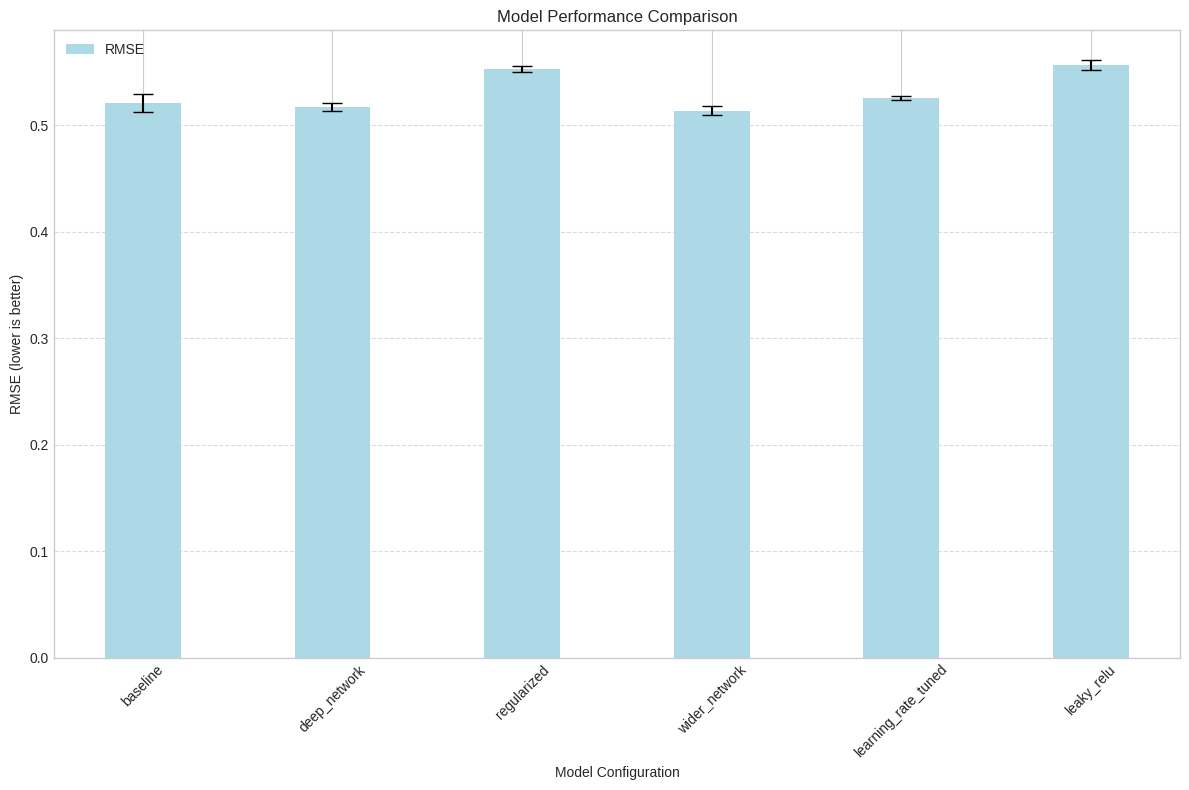

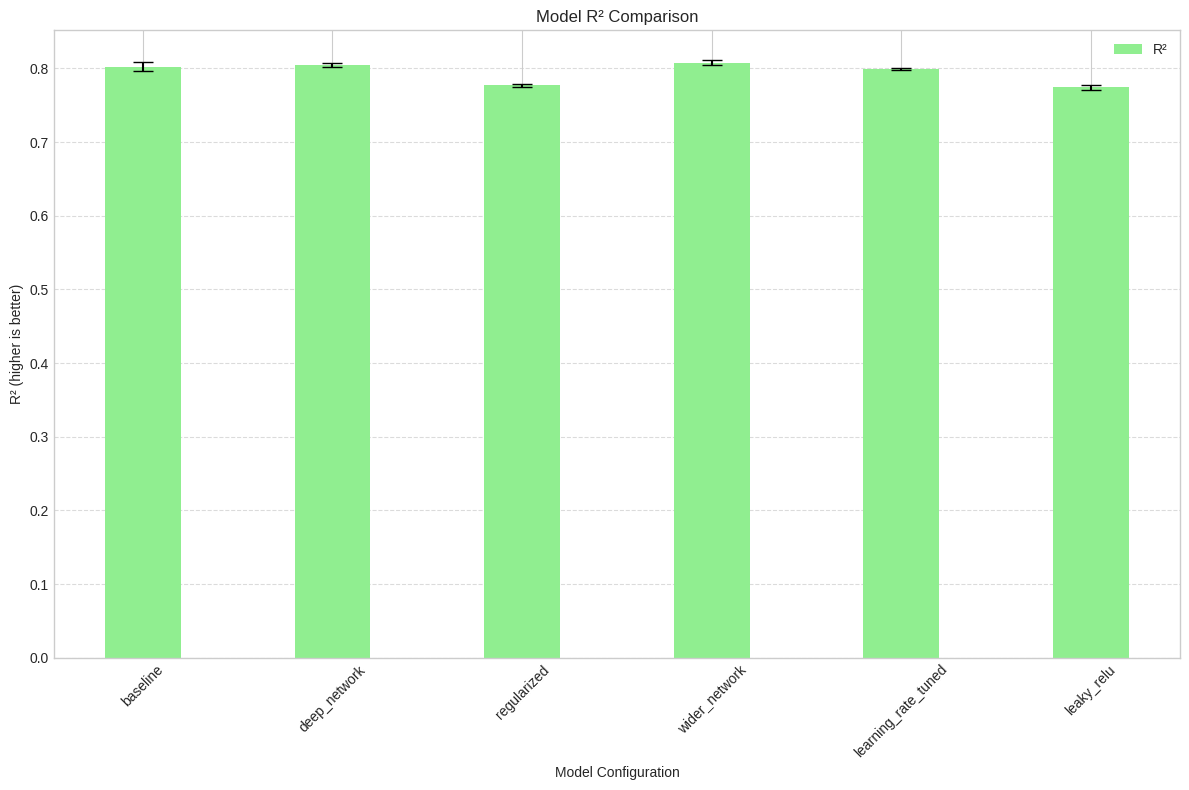

In [10]:
# Create results DataFrame
results_df = pd.DataFrame([
    {
        "Configuration": r["config"],
        "Mean RMSE": r["mean_metrics"]["rmse"],
        "Std RMSE": r["std_metrics"]["rmse"],
        "Mean MAE": r["mean_metrics"]["mae"],
        "Std MAE": r["std_metrics"]["mae"],
        "Mean R²": r["mean_metrics"]["r2"],
        "Std R²": r["std_metrics"]["r2"]
    } for r in all_results
])

# Display sorted results (best RMSE first)
print("Results sorted by RMSE (lower is better):")
print(results_df.sort_values("Mean RMSE").to_string(index=False))

# Get best configuration based on RMSE
best_config_idx = results_df["Mean RMSE"].idxmin()
best_config_name = results_df.loc[best_config_idx, "Configuration"]
best_config = next(c for c in configs if c["name"] == best_config_name)

print(f"\nBest configuration: {best_config_name}")
print(f"Mean RMSE: {results_df.loc[best_config_idx, 'Mean RMSE']:.4f}")
print(f"Mean R²: {results_df.loc[best_config_idx, 'Mean R²']:.4f}")

# Plot performance comparison
plt.figure(figsize=(12, 8))

# Create bar chart with error bars for RMSE
x = np.arange(len(results_df))
width = 0.4

plt.bar(x, results_df["Mean RMSE"], width,
        yerr=results_df["Std RMSE"],
        label='RMSE',
        color='lightblue',
        ecolor='black',
        capsize=7)

plt.xlabel('Model Configuration')
plt.ylabel('RMSE (lower is better)')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df["Configuration"], rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 8))
plt.bar(x, results_df["Mean R²"], width,
        yerr=results_df["Std R²"],
        label='R²',
        color='lightgreen',
        ecolor='black',
        capsize=7)

plt.xlabel('Model Configuration')
plt.ylabel('R² (higher is better)')
plt.title('Model R² Comparison')
plt.xticks(x, results_df["Configuration"], rotation=45)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Final Model Evaluation



Training final model with best configuration: wider_network


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,329 (138.00 KB)

 Trainable params: 35,329 (138.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7594 - mae: 0.9075 - val_loss: 0.5559 - val_mae: 0.4793
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5835 - mae: 0.5048 - val_loss: 0.4842 - val_mae: 0.4426
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5132 - mae: 0.4706 - val_loss: 0.4574 - val_mae: 0.4350
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4875 - mae: 0.4600 - val_loss: 0.4814 - val_mae: 0.4316
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4813 - mae: 0.4563 - val_loss: 0.4227 - val_mae: 0.4271
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4430 - mae: 0.4435 - val_loss: 0.4163 - val_mae: 0.4207
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4349 - mae: 0.4410 - val_loss: 0.3989 - val_mae: 0.4116
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4223 - mae: 0.4284 - val_loss: 0.4094 - val_mae: 0.4080
Epoch 9/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

2025/04/22 15:49:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/04/22 15:49:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 19ea3d0bad6a42628da31ce13ed5e3e2
RMSE: 0.5134
MAE: 0.3487
R²: 0.8080

Evaluating final model on test set:
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test RMSE: 0.5159
Test MAE: 0.3495
Test R²: 0.7969


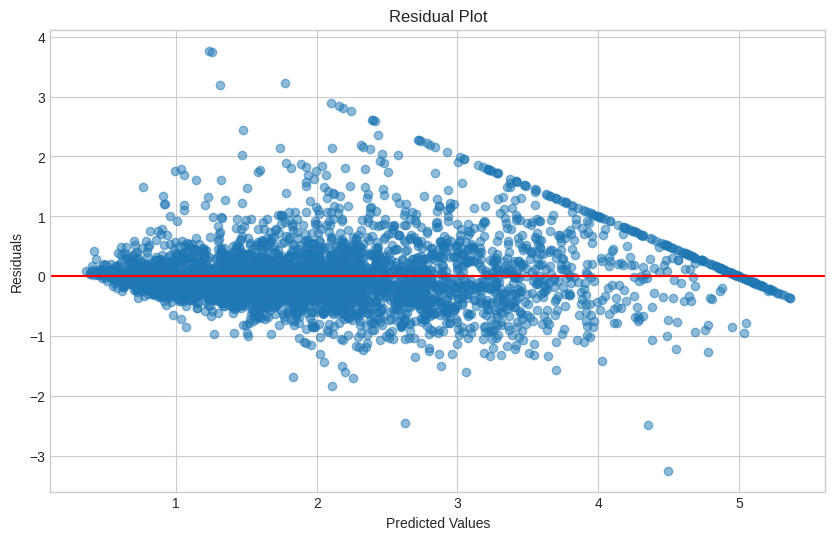

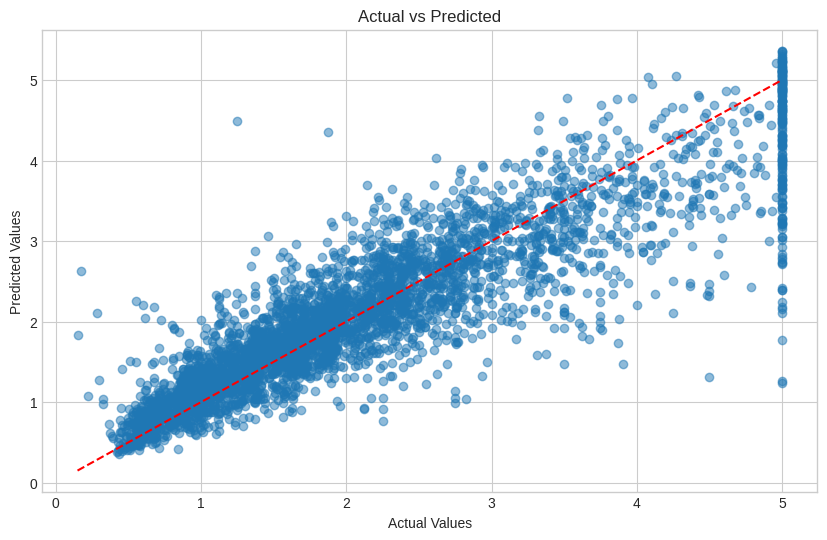

Final model saved to: ./final_model_wider_network.keras


In [13]:
# Build final model with best configuration
final_model = build_model(
    input_dim=X_train.shape[1],
    hidden_layers=best_config["hidden_layers"],
    activation=best_config["activation"],
    dropout_rate=best_config["dropout_rate"],
    learning_rate=best_config["learning_rate"],
    l2_reg=best_config["l2_reg"]
)

# Train final model
print(f"Training final model with best configuration: {best_config_name}")
final_history, final_trained_model = train_model(
    model=final_model,
    X_train=X_train_scaled,
    y_train=y_train,
    X_val=X_val_scaled,
    y_val=y_val,
    batch_size=best_config["batch_size"],
    epochs=best_config["epochs"],
    patience=best_config["patience"],
    run_name=f"final_{best_config_name}"
)

# Evaluate on test set
print("\nEvaluating final model on test set:")
test_metrics = evaluate_model(final_trained_model, X_test_scaled, y_test)

# Save final model
final_model_path = f"./final_model_{best_config_name}.keras" # Added .keras extension
final_trained_model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

## Visualize Training Logs



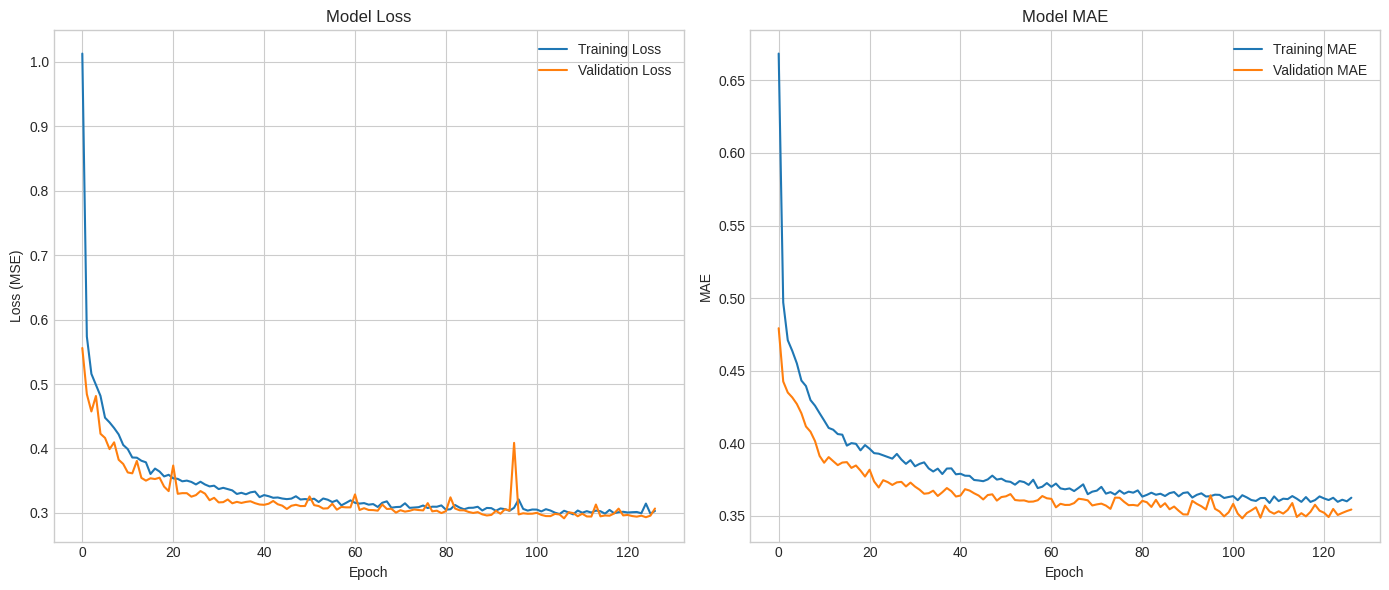

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


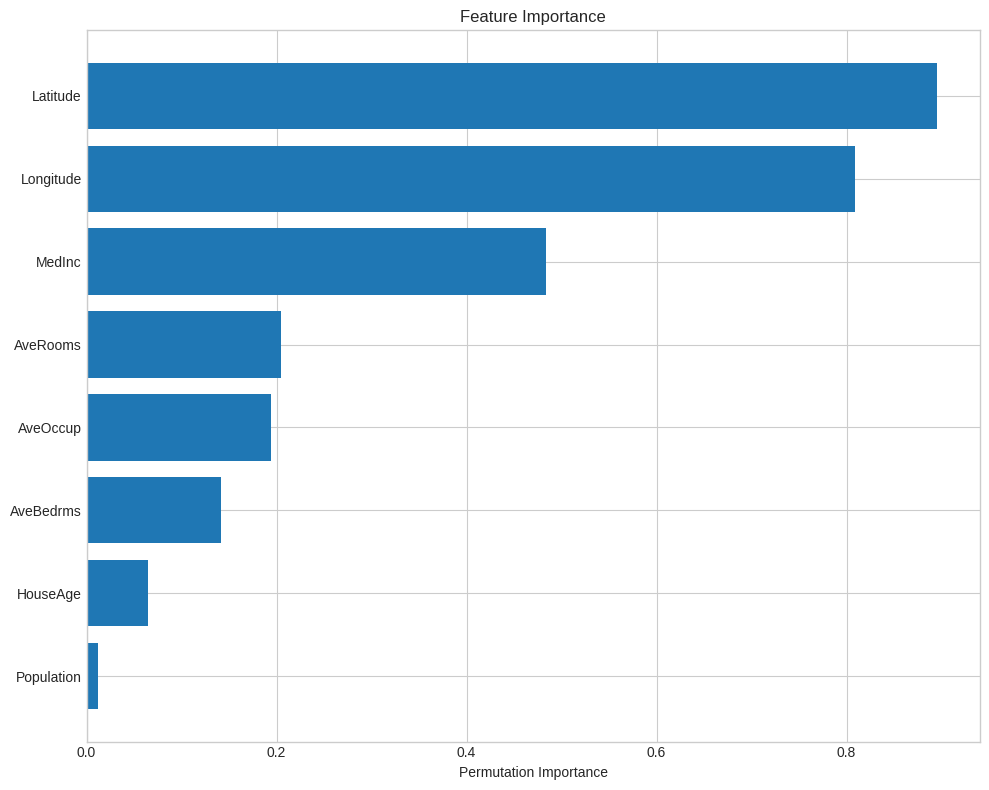

In [15]:
# Plot training history of final model
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Training MAE')
plt.plot(final_history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Feature importance analysis (using a simple approach with permutation)
from sklearn.inspection import permutation_importance

def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X).flatten()
    return r2_score(y, y_pred)  # Using R-squared as the scoring metric


perm_importance = permutation_importance(
    final_trained_model, X_test_scaled, y_test,
    scoring=custom_scorer,  # Pass the custom scoring function
    n_repeats=10, random_state=42, n_jobs=-1
)


# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh([feature_names[i] for i in sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()